In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import pims
import trackpy as tp

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox


plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# 1. Paths and Read-In

In [2]:
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack

vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0331_090303_001.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)

frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"

# D-mid?
pixel_per_real_width = .75
mpp = 1.333  # microns_per_pixel
print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function
frames

img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

D MID - FHD, pixel_per_real_width =  0.75
real width (µm):  1440.36 
real height (µm): 810.2


2024_0331_090303_001
- time point1 till 23sec
- time point2 from 30/31 onwards

In [3]:
# Time vector
time = np.linspace(0, len(frames) / fps, len(frames))
ttrigger = 14  # seconds

time_idx = np.where(time <= ttrigger)[0][-1] 
print("tpoints 1 frames=", time_idx)
ttime = time[time_idx:]
num_frames = time_idx
#tpoint2 = np.where(time >= 30)[0][0]
#print("tpoints 2 frames=", tmax - tpoint2)

tpoints 1 frames= 839


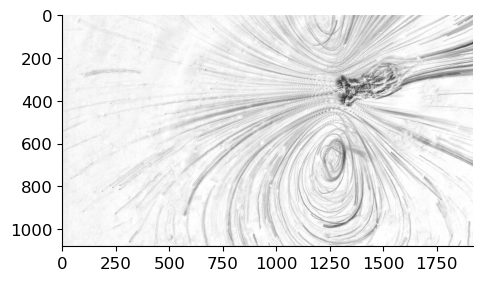

In [5]:
#show_frames = np.arange(tpoint2, tmax)
show_frames = np.arange(0, time_idx)

CALC_ZPROJ = False
if CALC_ZPROJ:
    zproj = []
    for n in show_frames:
        print(f"{n} / {show_frames[-1]}")
        zproj.append(frames[n].__array__() - frames[show_frames[0]].__array__())
    
    #zproj_ = np.max(np.stack(zproj), axis=0)
    zproj_min = np.min(np.stack(zproj), axis=0)
    del zproj

SAVE_NPY = False
if SAVE_NPY:
    np.save("./data/results/vortex/2024_0331_090303_001_zmin-proj-tpoint1.npy", zproj_min)
else:
    zproj_min = np.load("./data/results/vortex/2024_0331_090303_001_zmin-proj-tpoint1.npy")

vmin = -100
plt.figure()
plt.imshow(zproj_min, cmap="gray", vmin=np.min(zproj_min), vmax=0)  # show_frames = np.arange(tpoint2, tmax)
#plt.savefig(f"./data/results/vortex/2024_0331_090303_001-zmin-proj-tpoint1-till14sec-vmin_{vmin}.jpg", dpi=600)

## Locate features for single frame

n features -  199


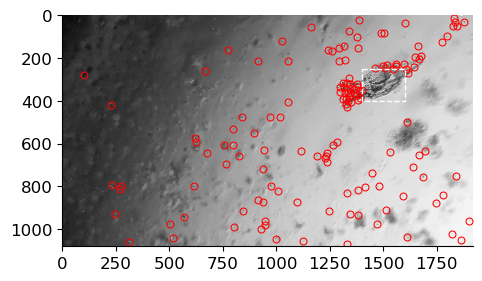

In [6]:
locate_params = {
    "diameter" : 11,
    "threshold" : 5,
    "invert" : True,
}
frame_nr = 0
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [1400, 1600, 250, 400]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]
# Detritus exclude
detritus_bbox = [1550, 1700, 510, 610]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});
#ax.set(xlim=(1250, 1750), ylim=(200, 450))
plot_bbox(rotifer_bbox)


# 2. Batch Process frames

In [7]:
tp.quiet()
fbatch = tp.batch(frames[:time_idx], **locate_params)

# lower_condition = (fbatch.y < 100) & (fbatch.x > 570)
# fbatch = fbatch[~lower_condition]
rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]
detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]
#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))
fbatch

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,11.139496,1828.875630,242.011668,1.538853,0.361154,26.438249,-13676.4374,-0.379419,0
1,21.952919,1387.919021,215.980161,2.411523,0.578036,16.269692,-11625.1507,-1.039673,0
2,28.810127,1833.532911,321.326416,2.004741,0.252045,25.624765,-13506.2318,-0.400524,0
3,30.057692,1878.839744,951.776979,2.451931,0.306120,46.775364,-12095.2947,-0.743240,0
4,35.771836,1599.975045,228.182430,1.886248,0.229606,15.049465,-12616.5323,-0.564726,0
...,...,...,...,...,...,...,...,...,...
168386,1044.379460,858.302002,473.792143,2.655601,0.140479,16.906421,-12136.0557,-0.720425,838
168387,1046.895833,1261.479167,237.514599,1.943651,0.166563,16.494069,-14228.0856,-0.323092,838
168388,1063.854237,1388.906780,243.287523,2.072827,0.455204,16.906421,-15699.5058,-0.232789,838
168389,1064.874257,965.204950,416.475252,2.015288,0.169260,28.864621,-13398.7314,-0.413501,838


# 3. Link particles / frames to trajectories

In [8]:
link_params = {
    "search_range" : 50,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/8); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 4502
7
N Before: 4502 
 N after filtering: 1811


[(1150.0, 1450.0), (200.0, 450.0)]

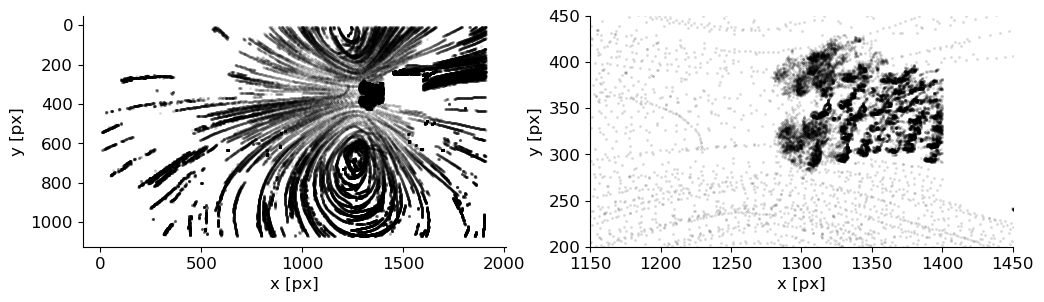

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
tp.scatter(trajs, ax=ax[0], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
tp.scatter(trajs, ax=ax[1], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
ax[1].set(xlim=(1150, 1450), ylim=(200, 450))

number of particles = number of trajectories: 1811
number of particles (original): 1811 
number of particles remaining: 607
number of particles = number of trajectories: 607


[(1150.0, 1450.0), (200.0, 450.0)]

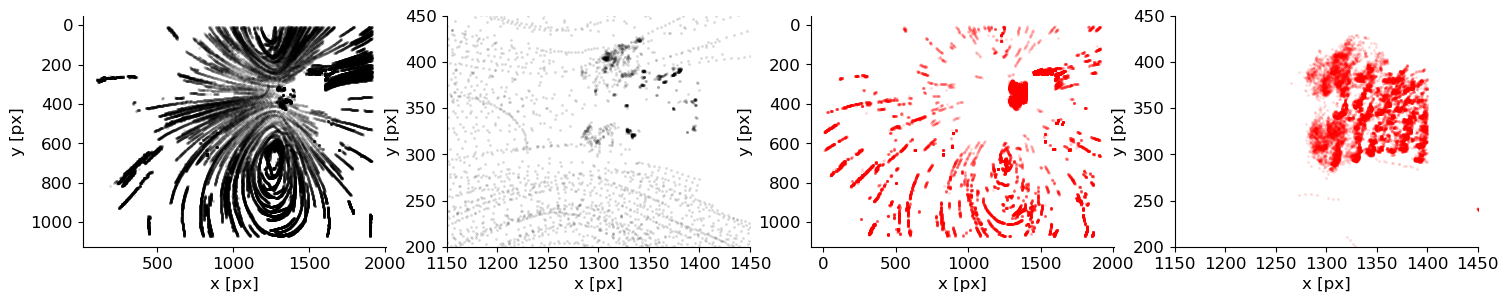

In [10]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 15) & (stats.y_std < 15)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

fig, ax = plt.subplots(1,4,figsize=(18,3))
tp.scatter(ctraj, ax=ax[0], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
ax[1].set(xlim=(1150, 1450), ylim=(200, 450))

tp.scatter(traj_rejected, ax=ax[2], plot_style={"ms" : 1, "alpha" : .15, "color" : "r", "mfc" : "none"});
tp.scatter(traj_rejected, ax=ax[3], plot_style={"ms" : 1, "alpha" : .15, "color" : "r", "mfc" : "none"});
ax[3].set(xlim=(1150, 1450), ylim=(200, 450))

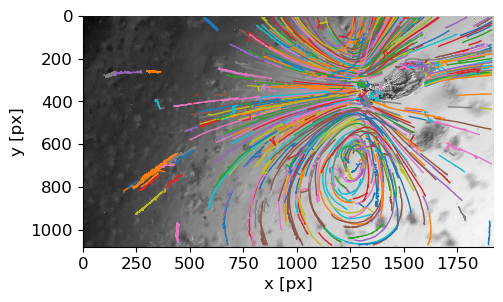

In [11]:
fig, ax = plt.subplots()
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=False, ax=ax);

## Visualize Trajectories

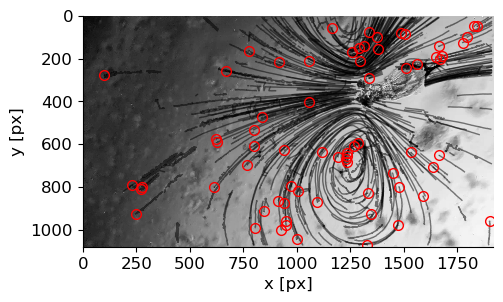

In [12]:
fig, ax = plt.subplots()
tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax, plot_style={"color": "k", "lw" : 1, "alpha" : .5});
tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax, plot_style={"markersize" : 7, "markeredgewidth" : 1}); 

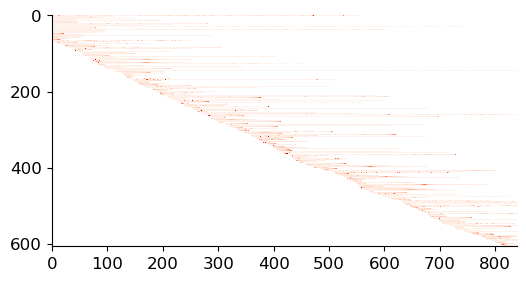

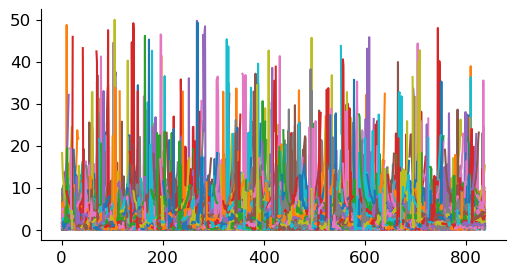

In [13]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, np.arange(0, time_idx))
displacement_array = (displacement_array)
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

plt.subplots()
plt.imshow(df_disp.values.T, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=np.nanmax(df_disp.values))#, extent=[0, fr_time[-1], displacement_array.shape[0], 0]

plt.subplots()
plt.plot(df_disp.values); # displacement_array.T

In [14]:
corona_center = (1300, 350)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]

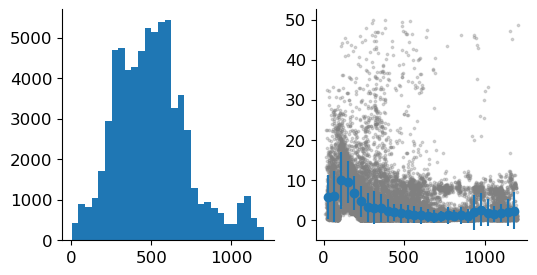

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')

0.0 26.46104983041331


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_87023/3755218913.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = ctraj.groupby(['rbin', 'angle_bin']).agg(


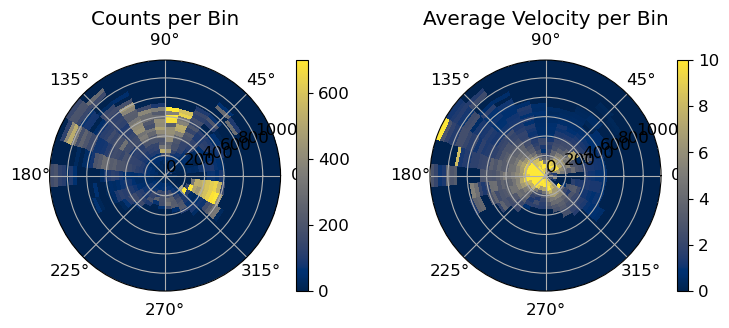

In [43]:
ctraj_['angle'] = np.arctan2(ctraj_['y'] - corona_center[1], ctraj_['x'] - corona_center[0])

num_radial_bins = 30
num_angle_bins = 30
radial_bins = np.linspace(ctraj_['rdist'].min(), ctraj_['rdist'].max(), num_radial_bins + 1)
angle_bins = np.linspace(-np.pi, np.pi, num_angle_bins + 1)

ctraj_['rbin'] = pd.cut(ctraj_['rdist'], bins=radial_bins, include_lowest=True)
ctraj_['angle_bin'] = pd.cut(ctraj_['angle'], bins=angle_bins, include_lowest=True)

# Drop rows with NaN values from the diff operation
ctraj = ctraj_.dropna()

# Group by rbin and angle_bin, then calculate counts and mean velocity
bin_stats = ctraj.groupby(['rbin', 'angle_bin']).agg(
    count=('velocity', 'size'),
    mean_velocity=('velocity', 'mean'),
    std_velocity=('velocity', 'std')
).reset_index()

# Prepare data for plotting counts
counts = bin_stats.pivot(index='rbin', columns='angle_bin', values='count').fillna(0)
mean_velocities = bin_stats.pivot(index='rbin', columns='angle_bin', values='mean_velocity').fillna(0)
std_velocities = bin_stats.pivot(index='rbin', columns='angle_bin', values='std_velocity').fillna(0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(9, 3), subplot_kw=dict(projection='polar'))

# Plot counts
theta_counts = np.linspace(-np.pi, np.pi, len(counts.columns) + 1)
r_counts = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), len(counts.index) + 1)
theta_grid, r_grid = np.meshgrid(theta_counts, r_counts)
vmin_counts = counts.values.min()
vmax_counts = counts.values.max()
theta_grid = theta_grid[:-1, :-1]
r_grid = r_grid[:-1, :-1]

c = ax[0].pcolormesh(theta_grid, r_grid, counts.values, shading='auto', vmin=vmin_counts, vmax=700, cmap="cividis")
ax[0].set_title('Counts per Bin')
fig.colorbar(c, ax=ax[0])

# Plot average velocities
theta_vel = np.linspace(-np.pi, np.pi, len(mean_velocities.columns) + 1)
r_vel = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), len(mean_velocities.index) + 1)
theta_grid, r_grid = np.meshgrid(theta_vel, r_vel)
vmin_velocity = mean_velocities.values.min()
vmax_velocity = mean_velocities.values.max()
theta_grid = theta_grid[:-1, :-1]
r_grid = r_grid[:-1, :-1]
print(vmin_velocity, vmax_velocity)

c = ax[1].pcolormesh(theta_grid, r_grid, mean_velocities.values, shading='auto', vmin=vmin_velocity, vmax=10, cmap="cividis")
ax[1].set_title('Average Velocity per Bin')
fig.colorbar(c, ax=ax[1])

In [27]:
theta_grid.shape, r_grid.shape, counts.values.shape

((29, 11), (29, 11), (29, 11))